# MD-DTW Analysis Framework  for b9d2 analysis

## Setup: Configure Environment and Import Functions

In [11]:
import os

os.chdir(os.environ['MORPHSEQ_REPO_ROOT']) 

import pandas as pd

# Import MD-DTW analysis tools
from src.analyze.trajectory_analysis import (
    # Step 2: Array preparation
    prepare_multivariate_array,


    # Step 3: Distance computation
    compute_md_dtw_distance_matrix,

    # Step 4: Outlier detection
    identify_outliers,
    remove_outliers_from_distance_matrix,

    # Step 5: Clustering & visualization (NEW API)
    generate_dendrograms,
    add_cluster_column,
    run_bootstrap_hierarchical,
    analyze_bootstrap_results,
    plot_multimetric_trajectories,
    plot_trajectories_faceted,
    PASTEL_COLORS,

    # K-SELECTION PIPELINE (Phase 1) - SEPARATE FUNCTIONS for granular control
    evaluate_k_range,              # Evaluate multiple k values with metrics
    plot_k_selection,              # Visualize k comparison across all metrics
    classify_membership_2d,        # Core/uncertain/outlier classification

    # Consensus clustering (Phase 2)
    run_consensus_pipeline,        # Full two-stage pipeline
)

# Import add_membership_column from k_selection module directly
from src.analyze.trajectory_analysis.k_selection import add_membership_column

from src.analyze.trajectory_analysis import plot_dendrogram_with_categories

# For loading data
from src.analyze.trajectory_analysis import extract_trajectories_df

from pathlib import Path
results_dir = "results/mcolon/20251219_b9d2_phenotype_extraction"
plot_dir = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/plots")
plot_dir.mkdir(parents=True, exist_ok=True)

print("✓ Imports successful!")

✓ Imports successful!


## Step 1: Load and Filter Data

Load your trajectory data as a long-format DataFrame with columns:
- `embryo_id`: Unique identifier for each embryo
- `predicted_stage_hpf`: Time in hours post fertilization
- Metric columns (e.g., `baseline_deviation_normalized`, `total_length_um`, etc.)
- Optional: `genotype`, `pair`, or other categorical columns for visualization

In [9]:
# Example: Load your data
# Replace this with your actual data loading code

# Option 1: Load from CSV
# df = pd.read_csv('path/to/your/data.csv')

#Option 2: Use existing data loading utilities

from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe
# List all experiments you want to analyze together
experiment_ids = ['20251119','20251121', '20251125']  # Add your experiment IDs

# Load and combine
dfs = []
for exp_id in experiment_ids:
    df_exp = load_experiment_dataframe(exp_id, format_version='df03')
    df_exp['experiment_id'] = exp_id  # Track which experiment each row came from
    dfs.append(df_exp)
    print(f"✓ Loaded {exp_id}: {len(df_exp)} rows, {df_exp['embryo_id'].nunique()} embryos")

# Concatenate all experiments
df = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Combined data: {len(df)} rows, {df['embryo_id'].nunique()} embryos")
print(f"  Experiments: {df['experiment_id'].unique()}")

  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251119.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251119.csv
    Curvature: 10440 rows
    Metadata: 8086 rows
    ⚠️  Column divergence detected: ['baseline_deviation_um', 'total_length_um']
    📌 Suffixing: curvature keeps original, metadata gets '_meta'
    Merged on 'snip_id': 8086 rows
    Unique snip_ids: curvature=10440, metadata=8086, merged=8086
    ⚠️  2354 snip_ids only in curvature (dropped)
✓ Loaded 20251119: 8086 rows, 30 embryos
  Loading curvature from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/body_axis/summary/curvature_metrics_20251121.csv
  Loading metadata from: /net/trapnell/vol1/home/mdcolon/proj/morphseq/morphseq_playground/metadata/build06_output/df03_final_output_with_latents_20251121

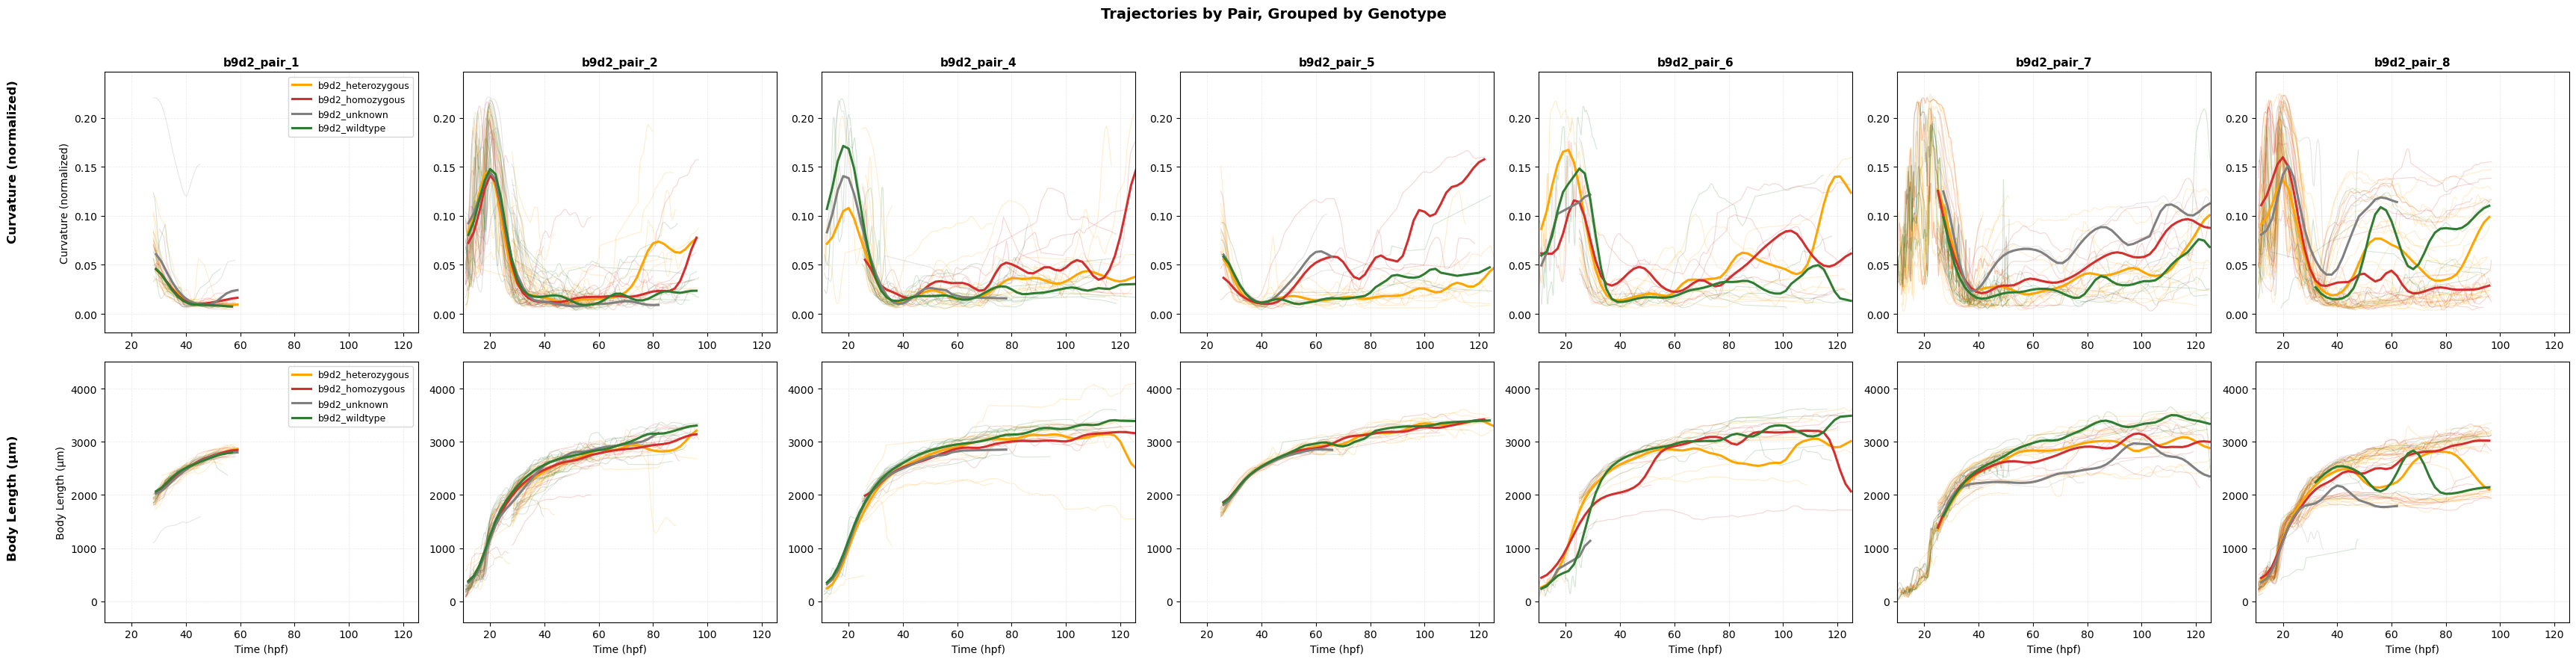

In [4]:
 
    # Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

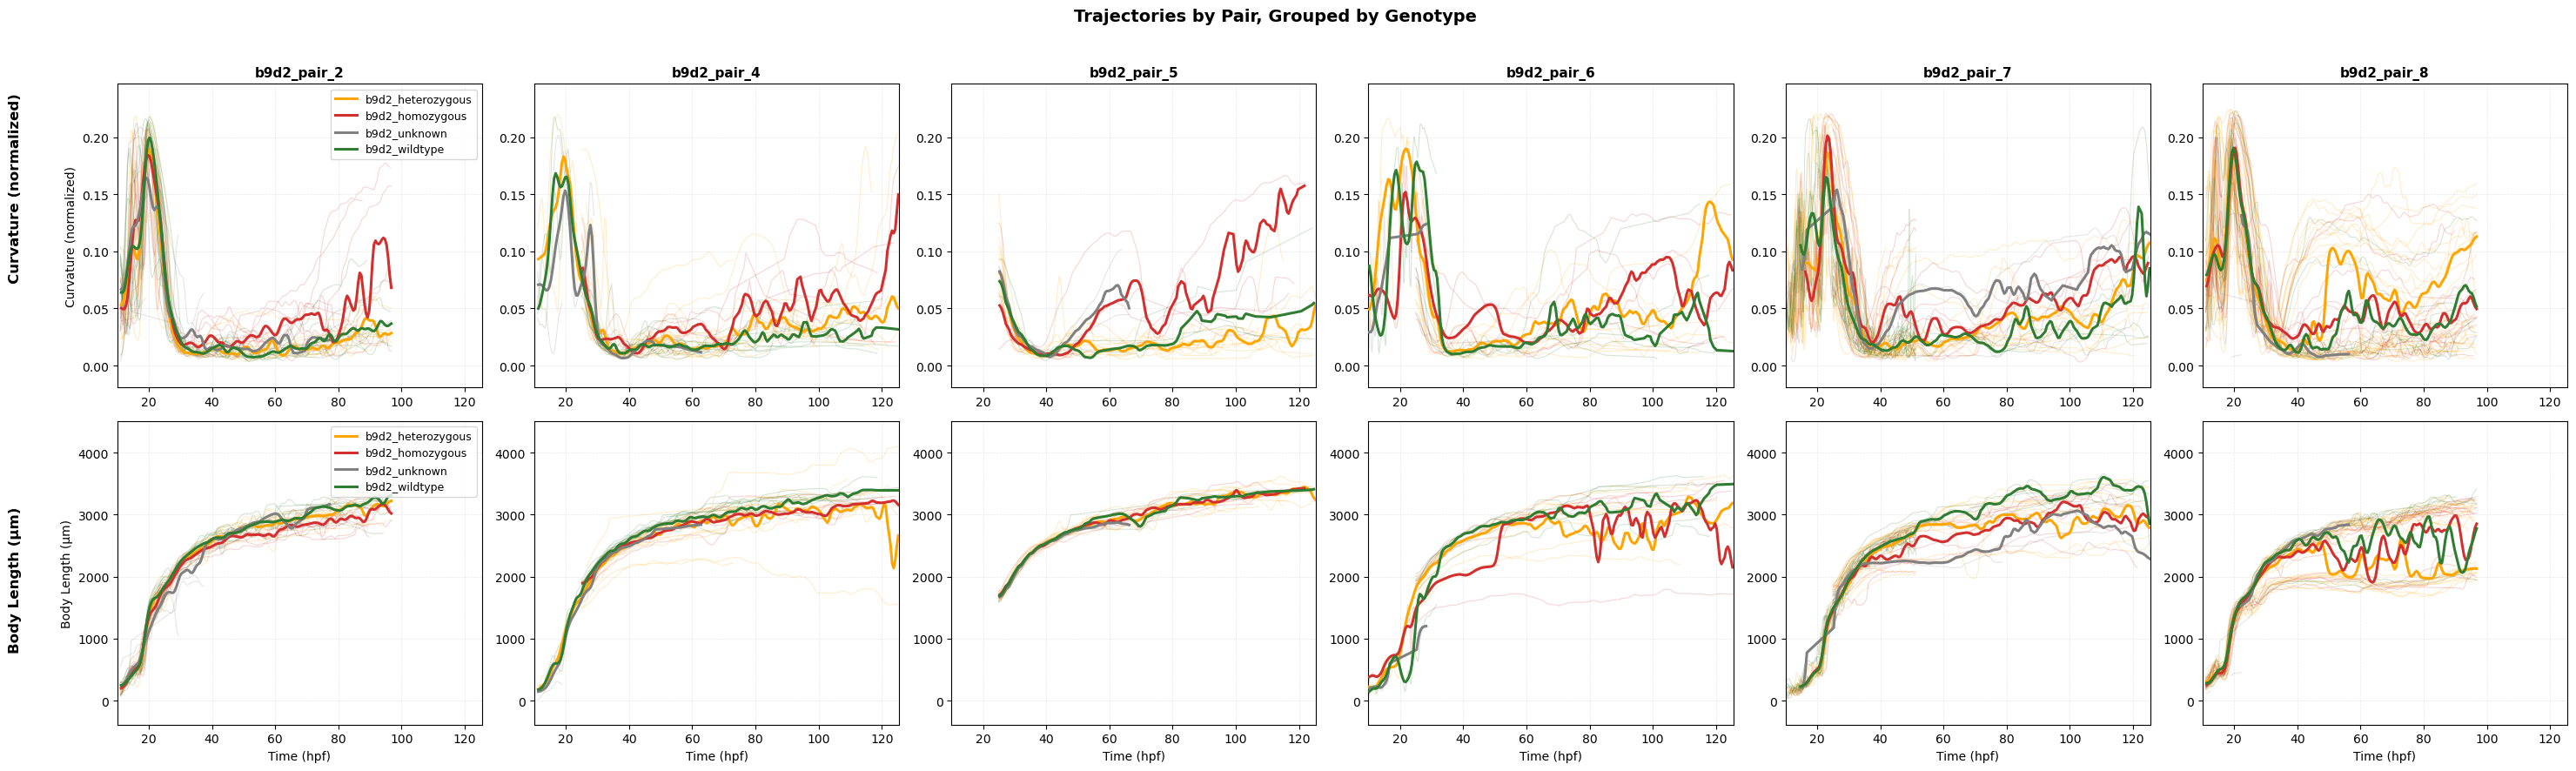

In [12]:

# Optional: Color by genotype instead to validate clusters separate genotypes
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='both',
        output_path=plot_dir / 'b9d2_pairs_trajectories_by_genotype.html',
    )

In [ ]:


plot_trajectories_faceted(
    df[~df["genotype"].str.contains("unknown")], 
    y_col='baseline_deviation_normalized',
    row_by='genotype', 
    col_by='pair',
    color_by_grouping='genotype',
    output_path=plot_dir / 'b9d2_curvuture_by_pairXgenotype_trajectories.html',
)

In [ ]:
# Example filters (uncomment to use)

# Filter by genotype
df_b9d2_pair_5 = df[df['pair'].isin(['b9d2_pair_5', ])].copy()

# Filter by time range
# df_filtered = df[(df['predicted_stage_hpf'] >= 24) & (df['predicted_stage_hpf'] <= 48)].copy()

# For this tutorial, use all data
df_filtered = df_b9d2_pair_5.copy()

print(f"✓ Filtered data: {df_filtered['embryo_id'].nunique()} embryos")

✓ Filtered data: 21 embryos


## K-SELECTION PIPELINE: Two-Phase Clustering with Membership Quality Assessment

This section integrates the two-phase k-selection pipeline to enable interactive exploration of optimal k and identification of phenotypic clusters.

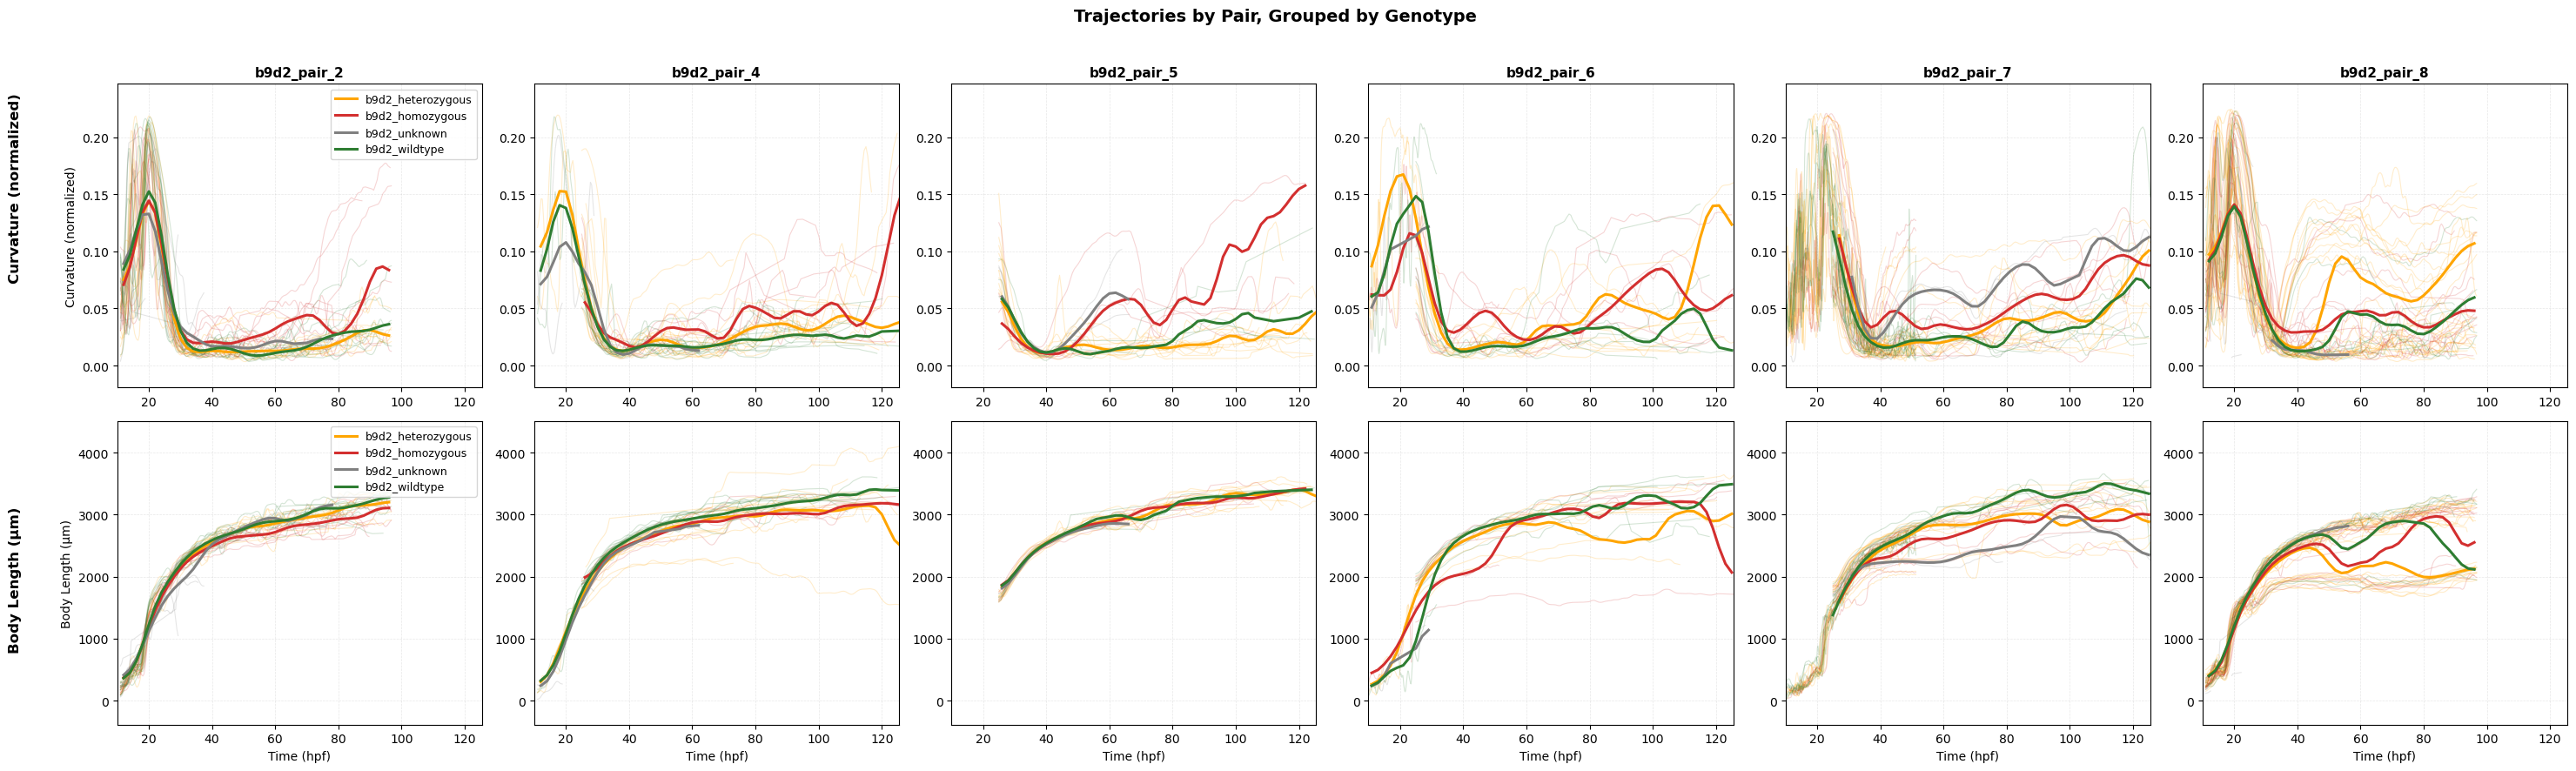

In [13]:
  
# Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='matplotlib',
        bin_width=2.0,
    )

In [14]:
df_filtered = df.copy()


# Define which metrics to use
metrics = ['baseline_deviation_normalized', 'total_length_um']

# Prepare multivariate array
X, embryo_ids, time_grid = prepare_multivariate_array(
    df_filtered,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")
print(f"  Embryo IDs: {embryo_ids[:3]}... ({len(embryo_ids)} total)")
print(f"  Time grid: {time_grid[:3]}... ({len(time_grid)} points)")


# Compute MD-DTW distance matrix
D = compute_md_dtw_distance_matrix(
    X,
    sakoe_chiba_radius=3,  # Warping constraint (3 is good default)
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D.shape}")
print(f"  Distance range: [{D[D > 0].min():.3f}, {D.max():.3f}]")

#Note to self, that this step should always go together, prepare array is an internal function only used to compute D, adidtionally i dont like how D is seprate
# from the embryo_ids. This should be fixed in future versions.


Preparing multivariate array for 2 metrics...
  Metrics: ['baseline_deviation_normalized', 'total_length_um']
  Normalization: True
  Embryos: 217

Interpolating 2 metrics to common grid (step=0.5)
  Interpolated multi-metric shape: (32519, 5)
  Time points: 231 (10.0 - 125.0 hpf)
  Array shape: (217, 231, 2)
  Before normalization:
    baseline_deviation_normalized: mean=0.054, std=0.050
    total_length_um: mean=2409.357, std=825.596
  After normalization:
    baseline_deviation_normalized: mean=0.000000, std=1.000000
    total_length_um: mean=-0.000000, std=1.000000
✓ Multivariate array prepared successfully

✓ Array prepared:
  Shape: (217, 231, 2) (embryos × timepoints × metrics)
  Embryo IDs: ['20251119_A01_e01', '20251119_A02_e01', '20251119_A03_e01']... (217 total)
  Time grid: [10.  10.5 11. ]... (231 points)
Computing MD-DTW distance matrix (Pure Python/NumPy)...
  Embryos: 217
  Array shape: (217, 231, 2)
  Sakoe-Chiba radius: 3
  Processed 23650/23653 pairs (99%)...
✓ Dista

## Add Cluster Assignments and Membership Quality to DataFrame

In [15]:
# ============================================================================
# PHASE 1: K-SELECTION (Light Filtering)
# ============================================================================
print("="*70)
print("PHASE 1: K-SELECTION (Light Filtering)")
print("="*70)

# Step 1: Light IQR filtering (remove ~8% global outliers)
print("\nStep 1: Light IQR filtering (2.0× multiplier)...")


#NOte to self 
#function here to let you see the metrics and different thresholds would be nice. before selecting IQR, somehting like plot metirc outlier IQr Ranges. 

# Remove outliers and create clean distance matrix for Phase 1
D_phase1, embryo_ids_phase1, _ = remove_outliers_from_distance_matrix(
    D,
    embryo_ids,
    outlier_detection_method='iqr',
    outlier_threshold=2.0,
    verbose=True
)

PHASE 1: K-SELECTION (Light Filtering)

Step 1: Light IQR filtering (2.0× multiplier)...

Identifying outliers using 'iqr' method...
  Total embryos: 217
  Q1 (25th percentile): 147.039
  Q3 (75th percentile): 269.704
  IQR: 122.665
  IQR multiplier: 2.0×
  Threshold (Q3 + 2.0×IQR): 515.035
  Threshold: 515.035
  Outliers detected: 14
  Inliers retained: 203

  Outlier embryos:
    20251119_A01_e01: median_dist = 786.741
    20251119_A02_e01: median_dist = 746.202
    20251119_C04_e01: median_dist = 728.650
    20251119_D01_e01: median_dist = 839.428
    20251119_E01_e01: median_dist = 692.823
    20251121_A05_e01: median_dist = 793.415
    20251121_A07_e01: median_dist = 591.253
    20251125_D02_e01: median_dist = 742.690
    20251125_D12_e01: median_dist = 917.163
    20251125_E08_e01: median_dist = 715.465
    20251125_F04_e01: median_dist = 525.186
    20251125_F08_e01: median_dist = 647.431
    20251125_G12_e01: median_dist = 693.645
    20251125_H05_e01: median_dist = 588.671

✓ 

In [ ]:
# import sys
from pathlib import Path

# # Remove all cached trajectory_analysis modules
# modules_to_remove = [
#     'src.analyze.trajectory_analysis',
#     'src.analyze.trajectory_analysis.k_selection',
#     'src.analyze.trajectory_analysis.bootstrap_clustering',
#     'src.analyze.trajectory_analysis.cluster_classification',
#     'src.analyze.trajectory_analysis.dendrogram',
#     'src.analyze.trajectory_analysis.plotting',
# ]

# for module in modules_to_remove:
#     if module in sys.modules:
#         del sys.modules[module]
#         print(f"Removed: {module}")

# # Now import fresh
from src.analyze.trajectory_analysis.k_selection import run_k_selection_with_plots
from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe

print("✓ Successfully reimported all modules!")


print(f"Loaded {len(embryo_ids)} embryos")
print(f"Distance matrix shape: {D.shape}")
print(f"Trajectory data: {len(df)} rows")

results = run_k_selection_with_plots(
    df=df_filtered,
    D=D,
    embryo_ids=embryo_ids,
    output_dir=Path('/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/k_selection'),
    plotting_metrics=['baseline_deviation_normalized', 'total_length_um'],
    k_range=[2, 3, 4, 5, 6],
    n_bootstrap=100
)


✓ Successfully reimported all modules!
Loaded 217 embryos
Distance matrix shape: (217, 217)
Trajectory data: 31160 rows
K SELECTION WITH TRAJECTORY PLOTS
Output directory: results/k_selection
Plotting metrics: ['baseline_deviation_normalized', 'total_length_um']
K range: [2, 3, 4, 5, 6]

Evaluating k=2
Running 100 bootstrap iterations...
  Sampling 174/217 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bootstrap iterations

k=2 Summary:
  Core: 217 (100.0%)
  Uncertain: 0 (0.0%)
  Outlier: 0 (0.0%)
  Mean max_p: 0.996
  Mean entropy: 0.022
  Silhouette: 0.627

Evaluating k=3
Running 100 bootstrap iterations...
  Sampling 174/217 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/1

In [19]:
# Access best k
# best_k = results['best_k']  # e.g., 3
best_k  = 5 

print(f"best k is {best_k}")

# Get quality metrics for best k
quality = results['clustering_by_k'][best_k]['quality']
print(f"Core: {quality['pct_core']:.1f}%")
print(f"Silhouette: {quality['silhouette']:.3f}")

# Get cluster assignment for embryo at best k
embryo_to_cluster = results['clustering_by_k'][best_k]['assignments']['embryo_to_cluster']



# Check membership quality
# embryo_to_membership_quality = results['clustering_by_k'][best_k]['membership']['embryo_to_membership_quality']
# membership_quality = embryo_to_membership_quality['20251119_G07_E008']  # 'core', 'uncertain', or 'outlier'

# Compare across k values using summary
print(results['summary_df'])

# Add clustering results to DataFrame
df_filtered['cluster_on_all_b9d2_experiments'] = df_filtered['embryo_id'].map(embryo_to_cluster)


# df_filtered['membership_quality'] = df_filtered['embryo_id'].map(embryo_to_membership_quality)

# Verify
print(df_filtered[['embryo_id', 'cluster_on_all_b9d2_experiments']].drop_duplicates())
print(f"\nCluster distribution:")
print(df_filtered['cluster_on_all_b9d2_experiments'].value_counts().sort_index())
# print(f"\nMembership quality distribution:")
# print(df_filtered['membership_quality'].value_counts())


best k is 5
Core: 99.5%
Silhouette: 0.533
   k    pct_core  pct_uncertain  pct_outlier  mean_max_p  mean_entropy  \
0  2  100.000000       0.000000          0.0    0.995819      0.021570   
1  3   97.235023       2.764977          0.0    0.986390      0.044526   
2  4   99.539171       0.460829          0.0    0.975157      0.142169   
3  5   99.539171       0.460829          0.0    0.993408      0.032557   
4  6   96.313364       3.686636          0.0    0.978994      0.077259   

   silhouette  
0    0.626663  
1    0.608338  
2    0.597418  
3    0.532807  
4    0.532807  
              embryo_id  cluster_on_all_b9d2_experiments
0      20251119_A01_e01                                2
107    20251119_A02_e01                                0
155    20251119_A03_e01                                4
455    20251119_A04_e01                                4
723    20251119_A05_e01                                1
...                 ...                              ...
30420  20251125_H0

Unique embryos per cluster:
cluster_on_all_b9d2_experiments
0      6
1    167
2      4
3      4
4     36
Name: count, dtype: int64


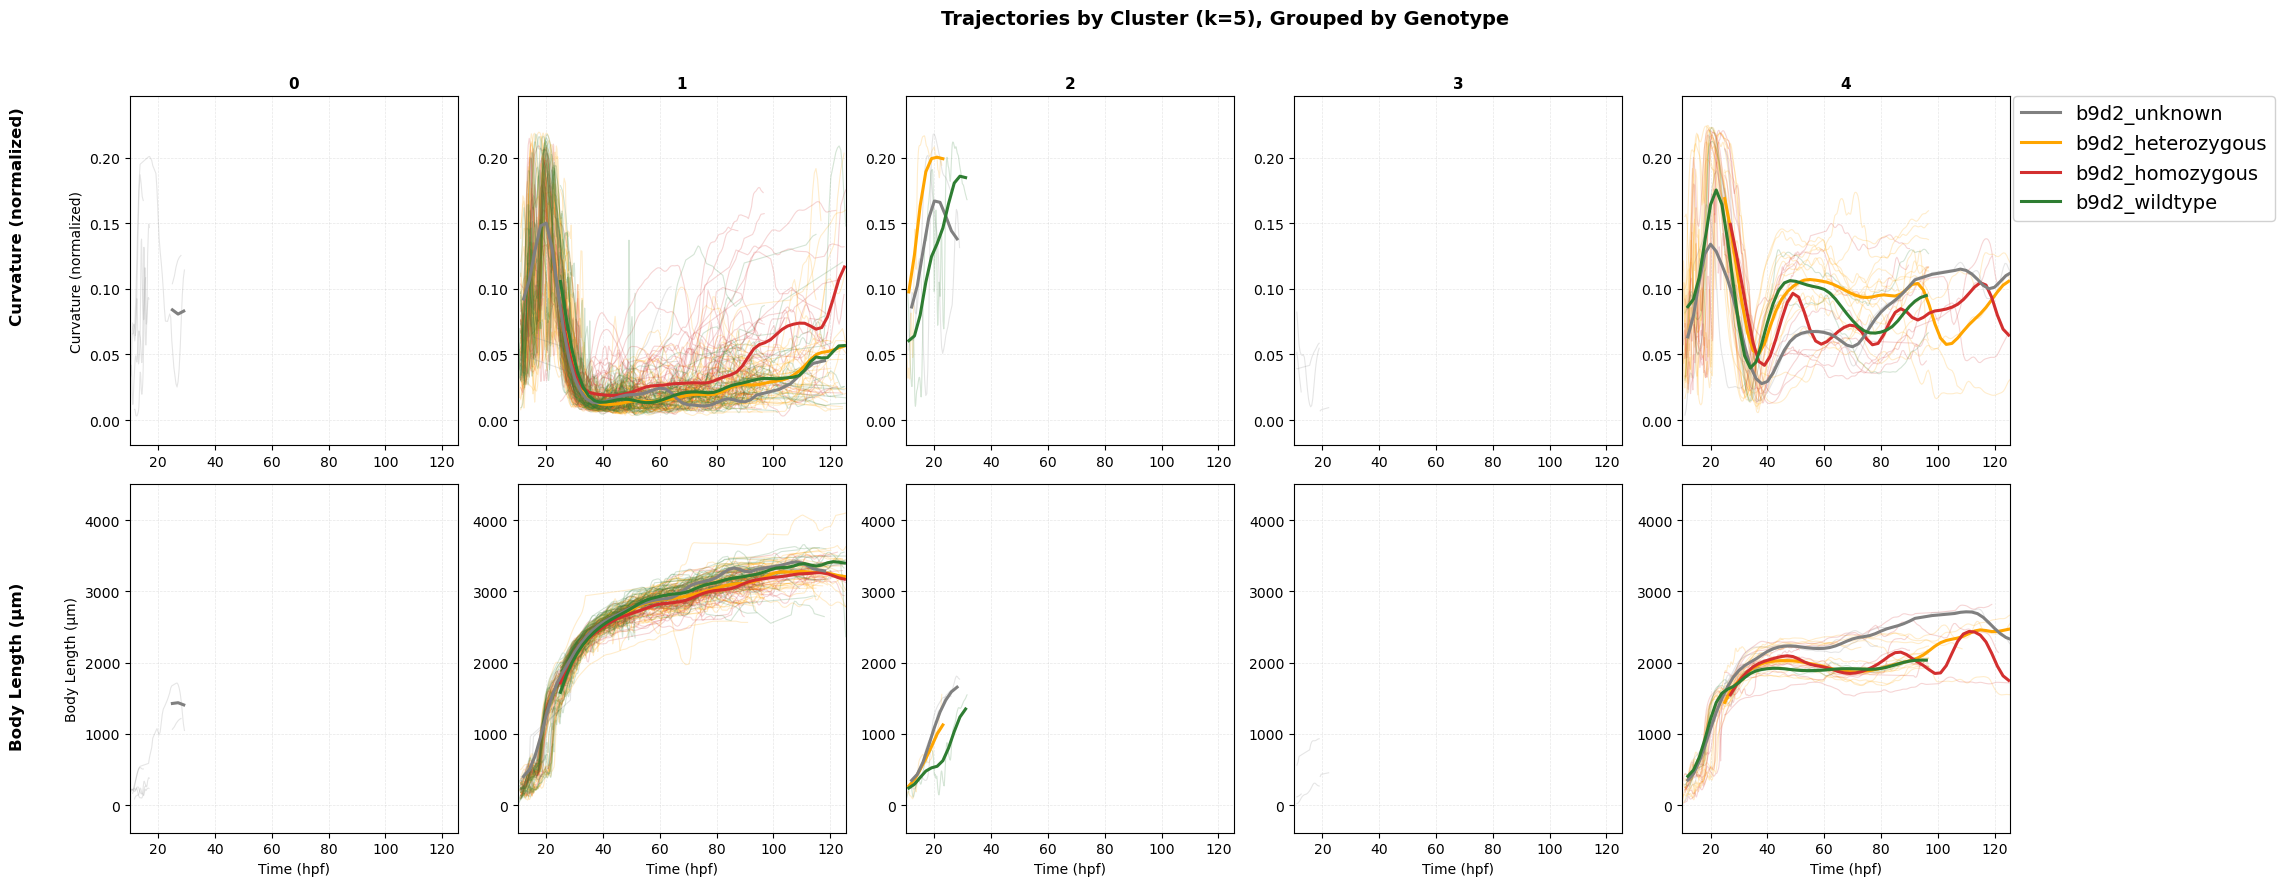

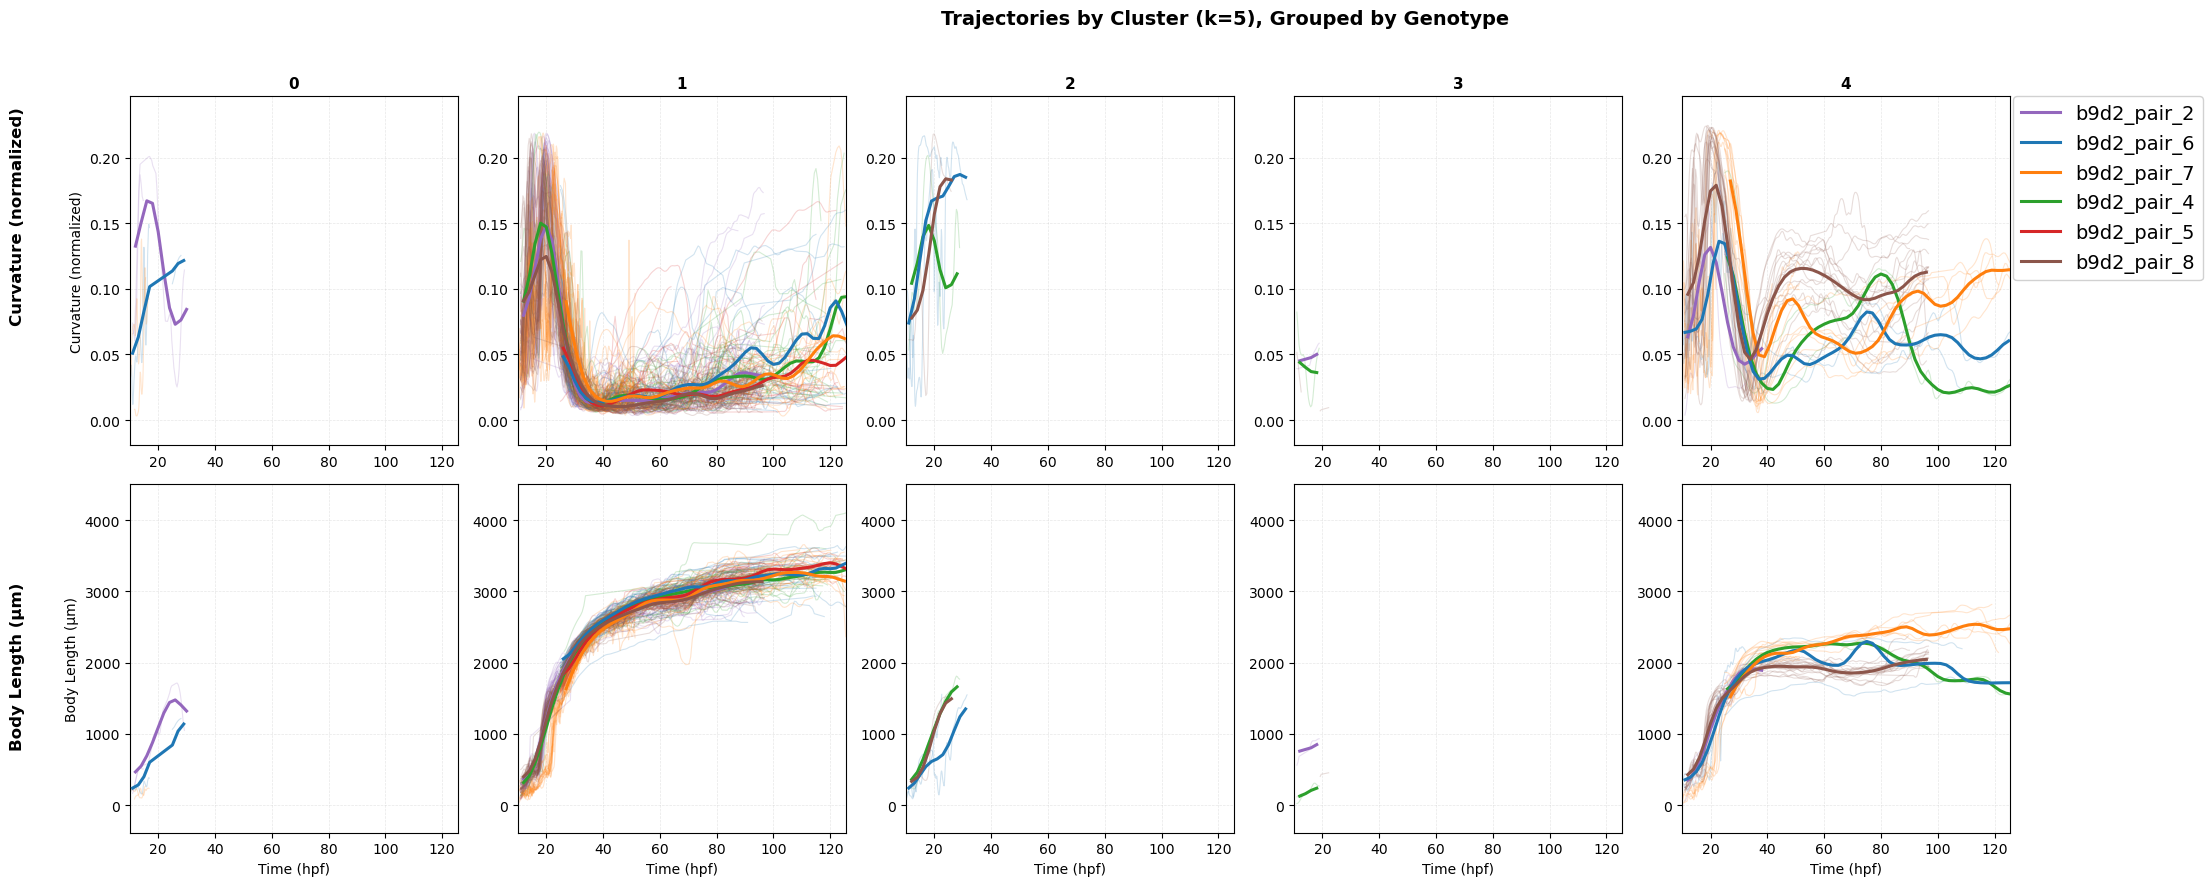

In [27]:
# Count embryos per cluster
import sys

modules_to_remove = [
    'src.analyze.trajectory_analysis',
    'src.analyze.trajectory_analysis.facetted_plotting',
]
for module in list(sys.modules.keys()):
    if module.startswith('src.analyze.trajectory_analysis'):
        del sys.modules[module]

# Re-import
from src.analyze.trajectory_analysis.facetted_plotting import plot_multimetric_trajectories


embryos_per_cluster = df_filtered.drop_duplicates(subset=['embryo_id'])['cluster_on_all_b9d2_experiments'].value_counts().sort_index()
print("Unique embryos per cluster:")
print(embryos_per_cluster)


fig_by_genotype = plot_multimetric_trajectories(
    df_filtered,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_all_b9d2_experiments',
    color_by_grouping='genotype',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

fig_by_genotype = plot_multimetric_trajectories(
    df_filtered,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_all_b9d2_experiments',
    color_by_grouping='pair',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    backend='matplotlib',
    bin_width=2.0,
)

In [29]:
import pandas as pd
import numpy as np

x_col = "predicted_stage_hpf"
metric = "baseline_deviation_normalized"
col_by = "cluster_on_all_b9d2_experiments"  # adjust
group = "genotype"                           # adjust

tmp = df_filtered[[x_col, metric, col_by, group]].dropna()
tmp[x_col] = pd.to_numeric(tmp[x_col], errors="coerce")
tmp = tmp.dropna(subset=[x_col])

# counts at early times (per facet + group)
early = tmp[tmp[x_col] <= (tmp[x_col].min() + 6)]
display(
    early.groupby([col_by, group]).size().reset_index(name="n_points").sort_values("n_points")
)

print("Global min time:", tmp[x_col].min())
print("Per-facet min time:")
display(tmp.groupby(col_by)[x_col].min().reset_index(name="min_time").sort_values("min_time"))

cluster_on_all_b9d2_experiments           genotype  n_points
11                                4       b9d2_unknown        23
6                                 2       b9d2_unknown        28
12                                4      b9d2_wildtype        28
8                                 3       b9d2_unknown        31
3                                 1       b9d2_unknown        51
5                                 2  b9d2_heterozygous        51
7                                 2      b9d2_wildtype        51
0                                 0       b9d2_unknown       164
10                                4    b9d2_homozygous       201
2                                 1    b9d2_homozygous       333
9                                 4  b9d2_heterozygous       385
4                                 1      b9d2_wildtype       588
1                                 1  b9d2_heterozygous       781

Global min time: 10.0
Per-facet min time:


cluster_on_all_b9d2_experiments  min_time
0                                0      10.0
1                                1      10.0
2                                2      10.0
4                                4      10.0
3                                3      11.0

In [21]:
cluster_to_embryos = results['clustering_by_k'][best_k]['assignments']['cluster_to_embryos']

# Define output directory
output_dir = Path('results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists')
output_dir.mkdir(parents=True, exist_ok=True)


# Define phenotypes
phenotypes = {
    4: 'CE-phenotype',
    1: 'NOT_CE',
}

# Save each phenotype to a file
for cluster_id, phenotype_name in phenotypes.items():
    embryo_list = cluster_to_embryos[cluster_id]

    # Save as text file (one embryo per line)
    output_file = output_dir / f'{phenotype_name}.txt'
    with open(output_file, 'w') as f:
        for embryo_id in embryo_list:
            f.write(f"{embryo_id}\n")

    print(f"✓ Saved {phenotype_name}: {len(embryo_list)} embryos → {output_file}")


✓ Saved CE-phenotype: 36 embryos → results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists/CE-phenotype.txt
✓ Saved NOT_CE: 167 embryos → results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists/NOT_CE.txt


In [25]:
df_filtered_no_CE = df_filtered[df_filtered['cluster_on_all_b9d2_experiments'] == 1].copy() # the other embryos are poor quality tracks

In [26]:
# Prepare multivariate array
X_no_CE, embryo_ids_no_CE, time_grid = prepare_multivariate_array(
    df_filtered_no_CE,
    metrics=metrics,
    time_col='predicted_stage_hpf',
    embryo_id_col='embryo_id',
    normalize=True,  # Z-score normalization (recommended)
    verbose=True
)

print(f"\n✓ Array prepared:")
print(f"  Shape: {X.shape} (embryos × timepoints × metrics)")
print(f"  Embryo IDs: {embryo_ids[:3]}... ({len(embryo_ids)} total)")
print(f"  Time grid: {time_grid[:3]}... ({len(time_grid)} points)")


# Compute MD-DTW distance matrix
D_no_CE = compute_md_dtw_distance_matrix(
    X_no_CE,
    sakoe_chiba_radius=3,  # Warping constraint (3 is good default)
    verbose=True
)

print(f"\n✓ Distance matrix computed: {D_no_CE.shape}")
print(f"  Distance range: [{D_no_CE[D_no_CE > 0].min():.3f}, {D_no_CE.max():.3f}]")

#Note to self, that this step should always go together, prepare array is an internal function only used to compute D, adidtionally i dont like how D is seprate
# from the embryo_ids. This should be fixed in future versions.


Preparing multivariate array for 2 metrics...
  Metrics: ['baseline_deviation_normalized', 'total_length_um']
  Normalization: True
  Embryos: 167

Interpolating 2 metrics to common grid (step=0.5)
  Interpolated multi-metric shape: (27055, 5)
  Time points: 231 (10.0 - 125.0 hpf)
  Array shape: (167, 231, 2)
  Before normalization:
    baseline_deviation_normalized: mean=0.040, std=0.040
    total_length_um: mean=2652.491, std=691.108
  After normalization:
    baseline_deviation_normalized: mean=-0.000000, std=1.000000
    total_length_um: mean=-0.000000, std=1.000000
✓ Multivariate array prepared successfully

✓ Array prepared:
  Shape: (217, 231, 2) (embryos × timepoints × metrics)
  Embryo IDs: ['20251119_A01_e01', '20251119_A02_e01', '20251119_A03_e01']... (217 total)
  Time grid: [10.  10.5 11. ]... (231 points)
Computing MD-DTW distance matrix (Pure Python/NumPy)...
  Embryos: 167
  Array shape: (167, 231, 2)
  Sakoe-Chiba radius: 3
  Processed 14020/14028 pairs (99%)...
✓ Dist

In [28]:
results = run_k_selection_with_plots(
    df=df_filtered_no_CE,
    D=D_no_CE,
    embryo_ids=embryo_ids_no_CE,
    output_dir=Path('results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE/'),
    plotting_metrics=['baseline_deviation_normalized', 'total_length_um'],
    k_range=[2, 3, 4, 5, 6, 7],
    n_bootstrap=100
)

K SELECTION WITH TRAJECTORY PLOTS
Output directory: results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE
Plotting metrics: ['baseline_deviation_normalized', 'total_length_um']
K range: [2, 3, 4, 5, 6, 7]

Evaluating k=2
Running 100 bootstrap iterations...
  Sampling 134/167 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bootstrap iterations

k=2 Summary:
  Core: 162 (97.0%)
  Uncertain: 5 (3.0%)
  Outlier: 0 (0.0%)
  Mean max_p: 0.988
  Mean entropy: 0.033
  Silhouette: 0.486

Evaluating k=3
Running 100 bootstrap iterations...
  Sampling 134/167 samples per iteration
  Progress: 10/100
  Progress: 20/100
  Progress: 30/100
  Progress: 40/100
  Progress: 50/100
  Progress: 60/100
  Progress: 70/100
  Progress: 80/100
  Progress: 90/100
  Progress: 100/100

Completed 100 successful bo

In [31]:
# Access best k
# best_k = results['best_k']  # e.g., 3
best_k = 3 #chose this as after looking at pot after this theres lotsd of singleton clusters. 

print(f"best k is {best_k}")

# Get quality metrics for best k
quality = results['clustering_by_k'][best_k]['quality']
print(f"Core: {quality['pct_core']:.1f}%")
print(f"Silhouette: {quality['silhouette']:.3f}")

# Get cluster assignment for embryo at best k
embryo_to_cluster = results['clustering_by_k'][best_k]['assignments']['embryo_to_cluster']

cluster_to_embryos = results['clustering_by_k'][best_k]['assignments']['cluster_to_embryos']

# Check membership quality
# embryo_to_membership_quality = results['clustering_by_k'][best_k]['membership']['embryo_to_membership_quality']
# membership_quality = embryo_to_membership_quality['20251119_G07_E008']  # 'core', 'uncertain', or 'outlier'

# Compare across k values using summary
print(results['summary_df'])

# Add clustering results to DataFrame
df_filtered_no_CE['cluster_on_b9d2_no_CE'] = df_filtered_no_CE['embryo_id'].map(embryo_to_cluster)


# df_filtered['membership_quality'] = df_filtered['embryo_id'].map(embryo_to_membership_quality)

# Verify
print(df_filtered_no_CE[['embryo_id', 'cluster_on_b9d2_no_CE']].drop_duplicates())
print(f"\nCluster distribution:")
print(df_filtered_no_CE['cluster_on_b9d2_no_CE'].value_counts().sort_index())




best k is 3
Core: 97.0%
Silhouette: 0.351
   k   pct_core  pct_uncertain  pct_outlier  mean_max_p  mean_entropy  \
0  2  97.005988       2.994012     0.000000    0.988022      0.033216   
1  3  97.005988       2.395210     0.598802    0.984313      0.052532   
2  4  95.209581       4.191617     0.598802    0.973440      0.116138   
3  5  95.209581       4.790419     0.000000    0.971556      0.133154   
4  6  90.419162       8.982036     0.598802    0.942821      0.263179   
5  7  77.245509      19.161677     3.592814    0.902425      0.457689   

   silhouette  
0    0.486131  
1    0.351155  
2    0.283212  
3    0.269675  
4    0.214618  
5    0.209015  
              embryo_id  cluster_on_b9d2_no_CE
723    20251119_A05_e01                      0
1158   20251119_B02_e01                      0
1437   20251119_B04_e01                      0
1765   20251119_B05_e01                      0
2409   20251119_C03_e01                      0
...                 ...                    ...
30420

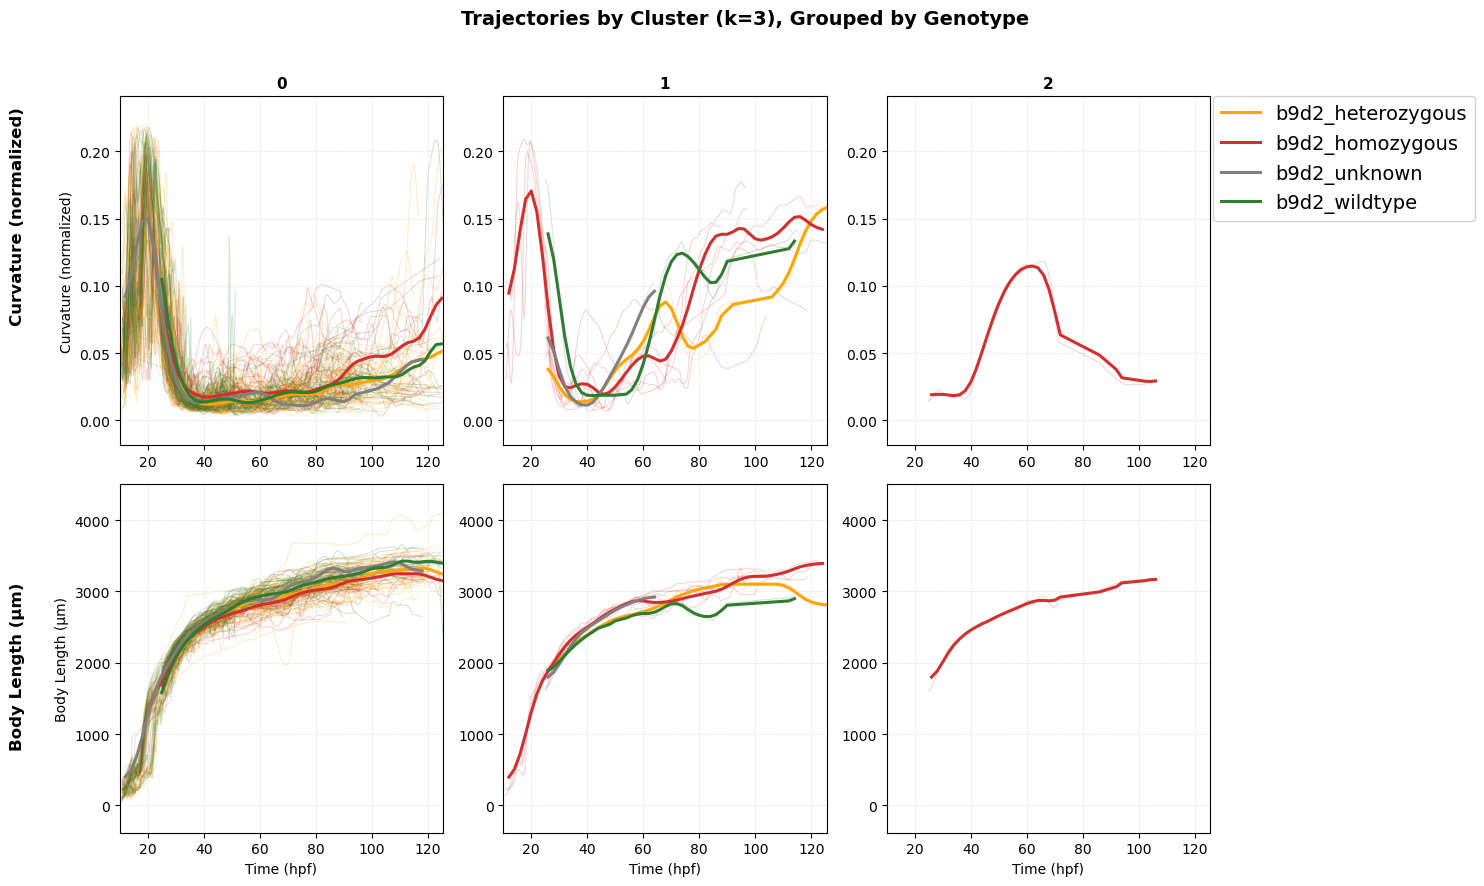

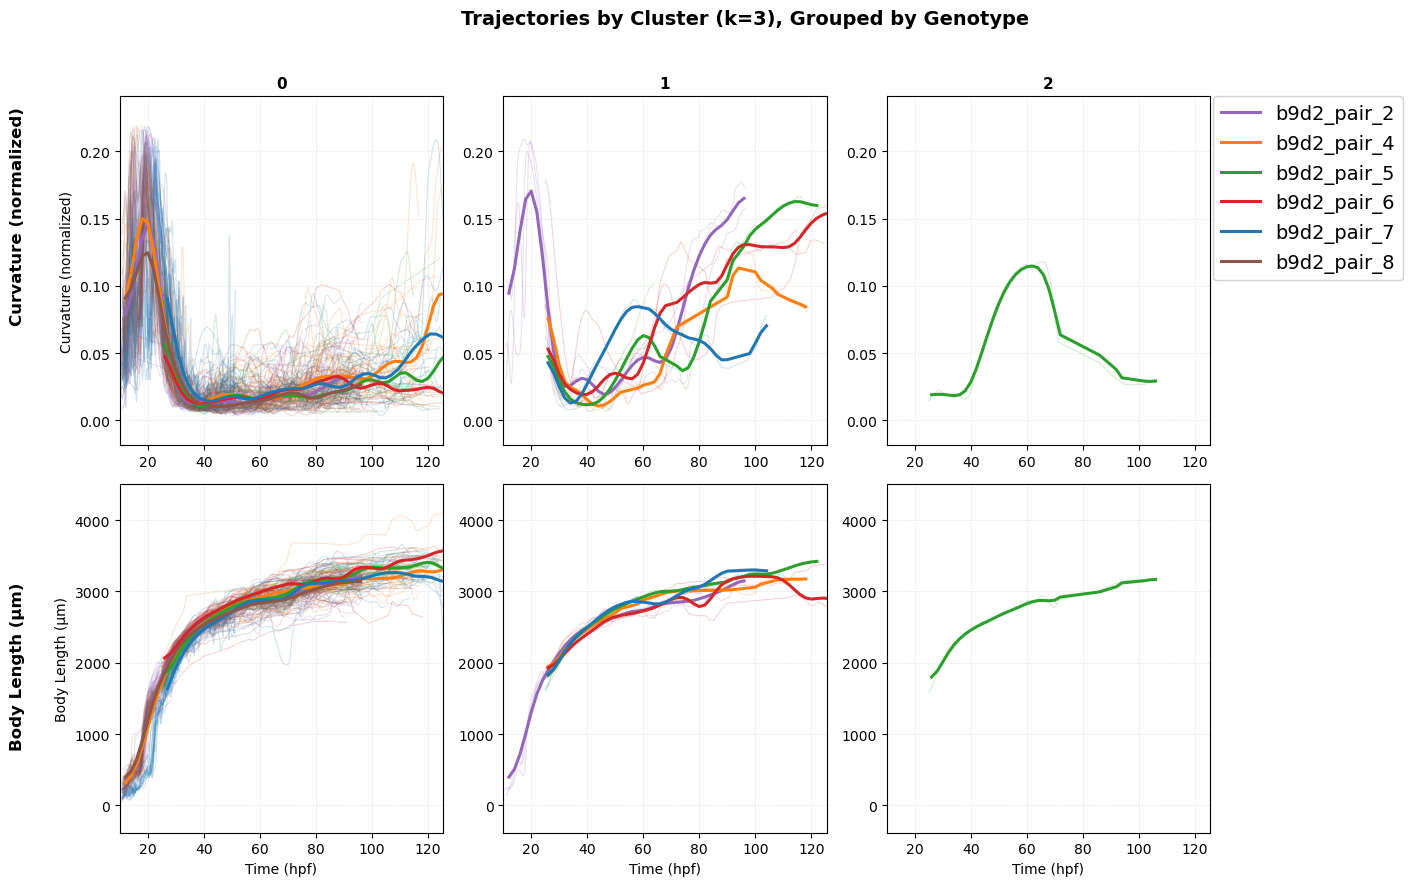

In [32]:
plot_dir=Path('results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE/')



fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='genotype',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='both',
    output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_genotype.html',
)

fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='pair',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Cluster (k={best_k}), Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='both',
    output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_cluster.html',
)

In [65]:

plot_trajectories_faceted(
    df_filtered_no_CE[~df_filtered_no_CE["genotype"].str.contains("unknown")], 
    y_col='baseline_deviation_normalized',
    row_by='genotype', 
    col_by='cluster_on_b9d2_no_CE',
    color_by_grouping='genotype',
    output_path=plot_dir / 'b9d2_no_CE_curvuture_by_clusterXgenotype_trajectories.html',
)


plot_trajectories_faceted(
    df_filtered_no_CE[~df_filtered_no_CE["genotype"].str.contains("unknown")], 
    y_col='baseline_deviation_normalized',
    row_by='genotype', 
    col_by='pair',
    color_by_grouping='genotype',
    output_path=plot_dir / 'b9d2_no_CE_curvuture_by_pairXgenotype_trajectories.html',
)

In [11]:
from pathlib import Path

# Define paths
phenotype_dir = Path('results/mcolon/20251219_b9d2_phenotype_extraction/phenotype_lists')

# Read CE-phenotype
with open(phenotype_dir / 'CE-phenotype.txt', 'r') as f:
    ce_phenotype = [line.strip() for line in f.readlines()]

# Read NOT_CE
with open(phenotype_dir / 'NOT_CE.txt', 'r') as f:
    not_ce = [line.strip() for line in f.readlines()]

# Verify
print(f"CE-phenotype: {len(ce_phenotype)} embryos")
print(ce_phenotype[:5])  # First 5
print(f"\nNOT_CE: {len(not_ce)} embryos")
print(not_ce[:5])  # First 5


CE-phenotype: 39 embryos
['20251104_A05_e01', '20251104_B06_e01', '20251104_C05_e01', '20251104_H02_e01', '20251119_A03_e01']

NOT_CE: 230 embryos
['20251104_A01_e01', '20251104_A02_e01', '20251104_A03_e01', '20251104_A04_e01', '20251104_A06_e01']


In [14]:
# Filter to the desired pair

df_filtered_no_CE = df[~df["embryo_id"].isin(ce_phenotype)].copy()  

df_pair = df_filtered_no_CE[df_filtered_no_CE["pair"] == "b9d2_pair_8"]

# Loop by genotype and print embryo_ids
for genotype, sub_df in df_pair.groupby("genotype"):
    embryo_ids = sub_df["embryo_id"].unique()
    print(f"\nGenotype: {genotype}")
    print(f"Embryo IDs ({len(embryo_ids)}):")
    for eid in embryo_ids:
        print(f"  - {eid}")


Genotype: b9d2_heterozygous
Embryo IDs (18):
  - 20251125_A10_e01
  - 20251125_B07_e01
  - 20251125_B09_e01
  - 20251125_B10_e01
  - 20251125_C06_e01
  - 20251125_D07_e01
  - 20251125_D08_e01
  - 20251125_D10_e01
  - 20251125_E06_e01
  - 20251125_E09_e01
  - 20251125_E11_e01
  - 20251125_F07_e01
  - 20251125_F10_e01
  - 20251125_G07_e01
  - 20251125_G09_e01
  - 20251125_G11_e01
  - 20251125_H07_e01
  - 20251125_H11_e01

Genotype: b9d2_homozygous
Embryo IDs (7):
  - 20251125_A07_e01
  - 20251125_A09_e01
  - 20251125_B08_e01
  - 20251125_C09_e01
  - 20251125_D09_e01
  - 20251125_E07_e01
  - 20251125_H06_e01

Genotype: b9d2_unknown
Embryo IDs (3):
  - 20251125_E08_e01
  - 20251125_F06_e01
  - 20251125_F08_e01

Genotype: b9d2_wildtype
Embryo IDs (6):
  - 20251125_B06_e01
  - 20251125_F09_e01
  - 20251125_G06_e01
  - 20251125_G08_e01
  - 20251125_H09_e01
  - 20251125_H10_e01


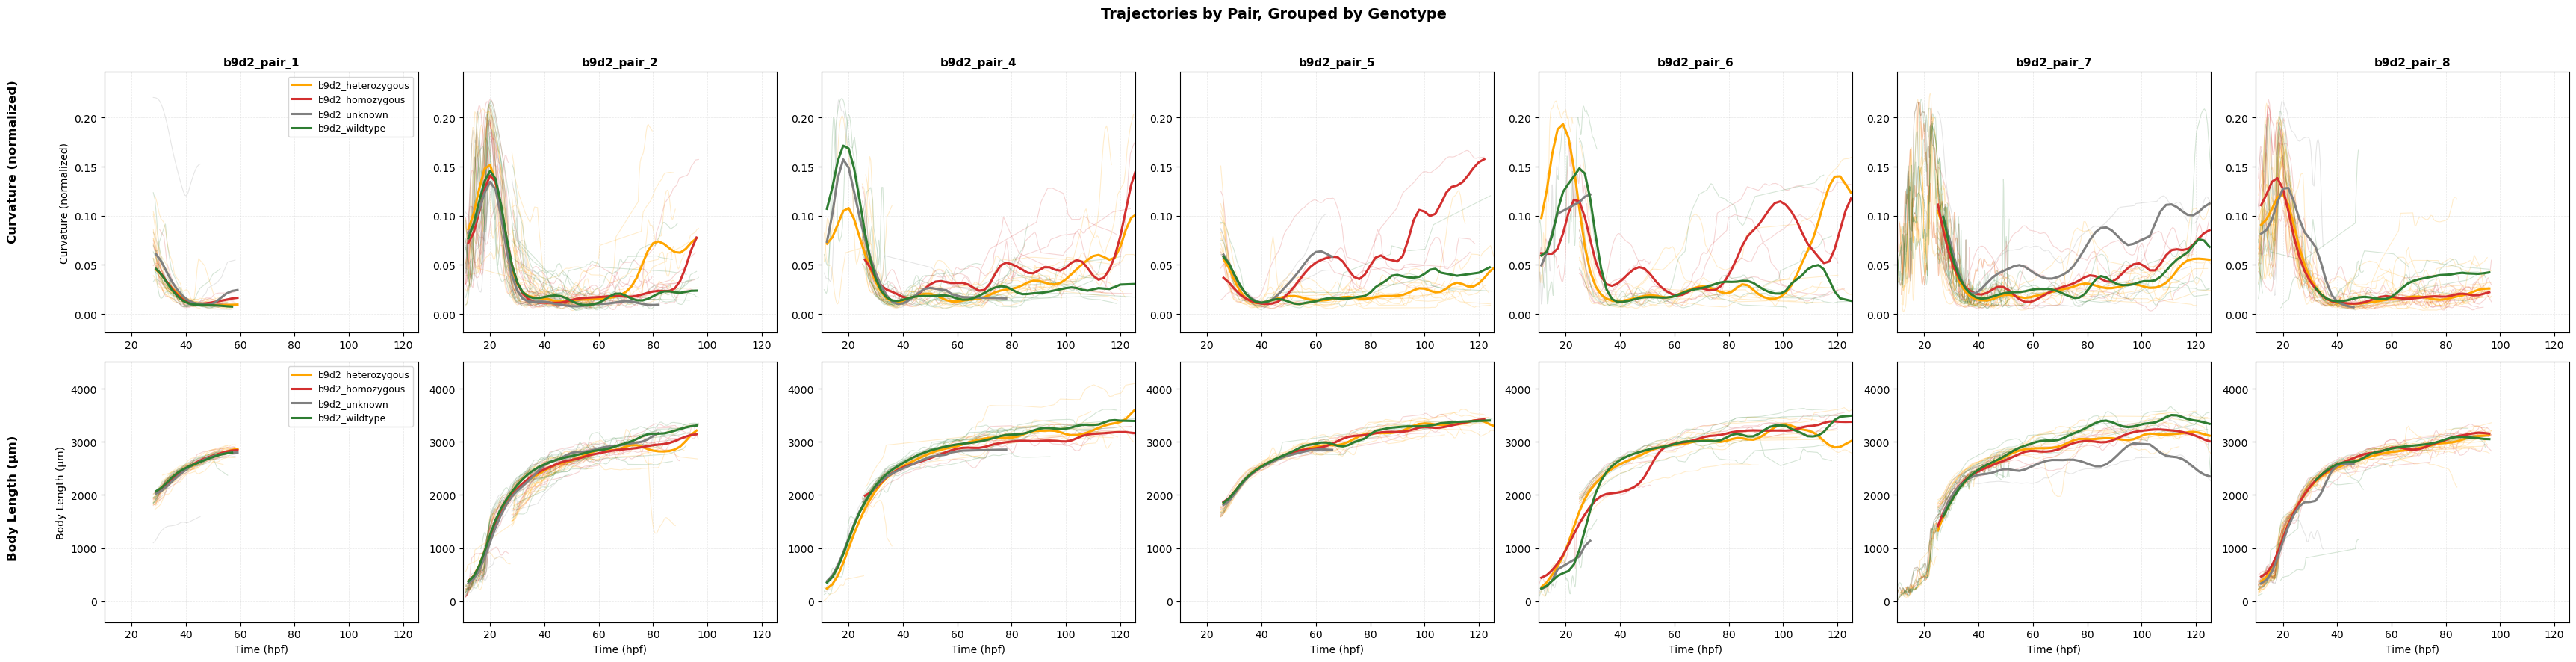

In [17]:
from pathlib import Path
plot_dir =  Path("results/mcolon/20251219_b9d2_phenotype_extraction/k_selection_no_CE")

fig_by_genotype = plot_multimetric_trajectories(
    df_filtered_no_CE,
    metrics=['baseline_deviation_normalized', 'total_length_um'],
    col_by='pair',
    color_by_grouping='genotype',  # NEW API
    x_col='predicted_stage_hpf',
    metric_labels={
        'baseline_deviation_normalized': 'Curvature (normalized)',
        'total_length_um': 'Body Length (μm)',
    },
    title=f'Trajectories by Pair, Grouped by Genotype',
    x_label='Time (hpf)',
    bin_width=2.0,
    backend='both',
    output_path=plot_dir / 'b9d2_pairs_trajectories_no_CE_by_pair_color_by_genotype.html',
)